In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

作圖格式
>  https://stackoverflow.com/questions/42277989/square-root-scale-using-matplotlib-python

In [2]:
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """

    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        super().__init__(axis, **kwargs)
        # 舊版用法
        # mscale.ScaleBase.__init__(self)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.array(a)**0.5

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)

## 觀察流失
`is_churn`意義為是否流失

In [5]:
df = pd.read_csv("~/data/kkbox/user_label_201702.csv")
df.head()

,msno,is_churn
0,++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=,False
1,+/HS8LzrRGXolKbxRzDLqrmwuXqPOYixBIPXkyNcKNI=,False
2,+/namlXq+u3izRjHCFJV4MgqcXcLidZYszVsROOq/y4=,False
3,+0/X9tkmyHyet9X80G6GTrDFHnJqvai8d1ZPhayT0os=,False
4,+09YGn842g6h2EZUXe0VWeC4bBoCbDGfUboitc0vIHw=,False


檢查缺失值

In [4]:
df.isna().sum()

msno        0
is_churn    0
dtype: int64

In [8]:
df.describe()

,msno,is_churn
count,879537,879537
unique,879537,2
top,9VpzSbqSIM+/dASgDXiIxV+ijNK9VsaFMHEuDHF+yRg=,False
freq,1,844756


流失的使用者非常少，少於25%

In [15]:
df.is_churn.quantile(0.5)

0.0

2017-3的流失量

In [16]:
df.groupby('is_churn').count()

,msno
is_churn,
False,844756
True,34781


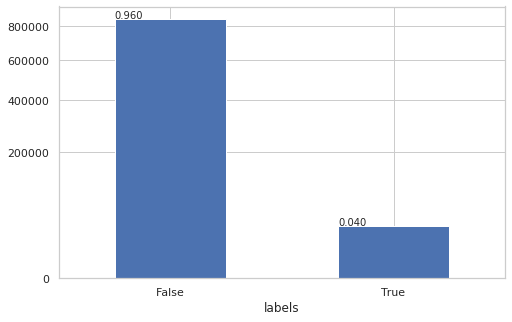

In [65]:
%matplotlib inline
# give labels
df_is_churn = df.groupby('is_churn').count().reset_index().rename(columns={'is_churn':'labels'})
# plot
ax =df_is_churn.plot(kind='bar', x='labels',y='msno',legend=False,figsize=(8,5))
plt.xticks(rotation=0)
# ax.set_yscale('log')
plt.yscale('squareroot')
# ax.set_yscale('squareroot')
# ticks the ratio
for p in ax.patches[:4]:
    ax.annotate('%.3f' % (p.get_height()/ df_is_churn.msno.sum()), (p.get_x() * 1.005, p.get_height() * 1.005))

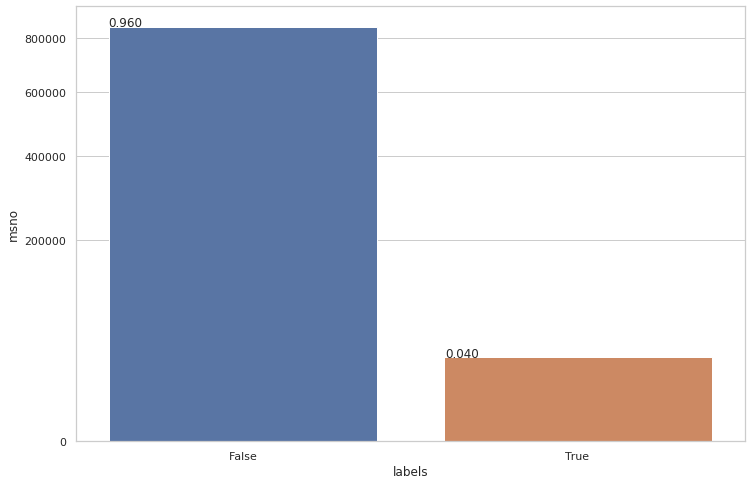

In [66]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,8))
g = sns.barplot(data = df_is_churn, x='labels',y='msno')
g.set(yscale='squareroot')

# ticks the ratio
for p in ax.patches[:4]:
    ax.annotate('%.3f' % (p.get_height()/ df_is_churn.msno.sum()), (p.get_x() * 1.005, p.get_height() * 1.005))

#### 會員是否流失的資料

In [9]:
df_train = pd.read_csv('~/data/kkbox/train.csv')
df_train.shape

(992931, 2)

## 觀察會員

In [6]:
df_member = pd.read_csv('~/data/kkbox/members_v3.csv')
df_member = pd.merge(df_member, df_train, how='left', on=['msno'])
df_member.head()

,msno,city,bd,gender,registered_via,registration_init_time,is_churn
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911,NaN
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914,0.0
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915,NaN
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915,NaN
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915,NaN


In [11]:
df_member.shape

(6769473, 7)

In [8]:
df_member.isna().sum()/ len(df_member)

msno                      0.000000
city                      0.000000
bd                        0.000000
gender                    0.654335
registered_via            0.000000
registration_init_time    0.000000
is_churn                  0.870424
dtype: float64

### 經由甚麼裝置註冊

In [16]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"}) # 設定樣式

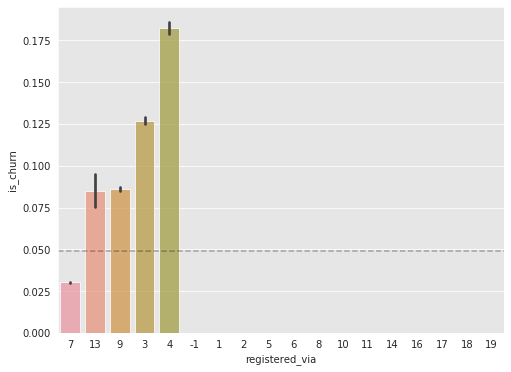

In [16]:
result_reg = df_member.groupby(["registered_via"])['is_churn'].mean().reset_index().sort_values('is_churn')
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='registered_via',y='is_churn',data=df_member,order=result_reg['registered_via'],ax=ax,alpha=.75)
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

### Age

In [45]:
df_member[['bd']].describe()

,bd
count,6769473.000
mean,9.796
std,17.926
min,-7168.000
25%,0.000
50%,0.000
75%,21.000
max,2016.000


In [24]:
# 有效年齡百分比
meaningful = (df_member.bd > 0 ) & (df_member.bd < 90)
print('Ages between 0 ~ 90   :  %.3f   ' %( len(df_member[meaningful]) / len(df_member) ))

Ages between 0 ~ 90   :  0.328   


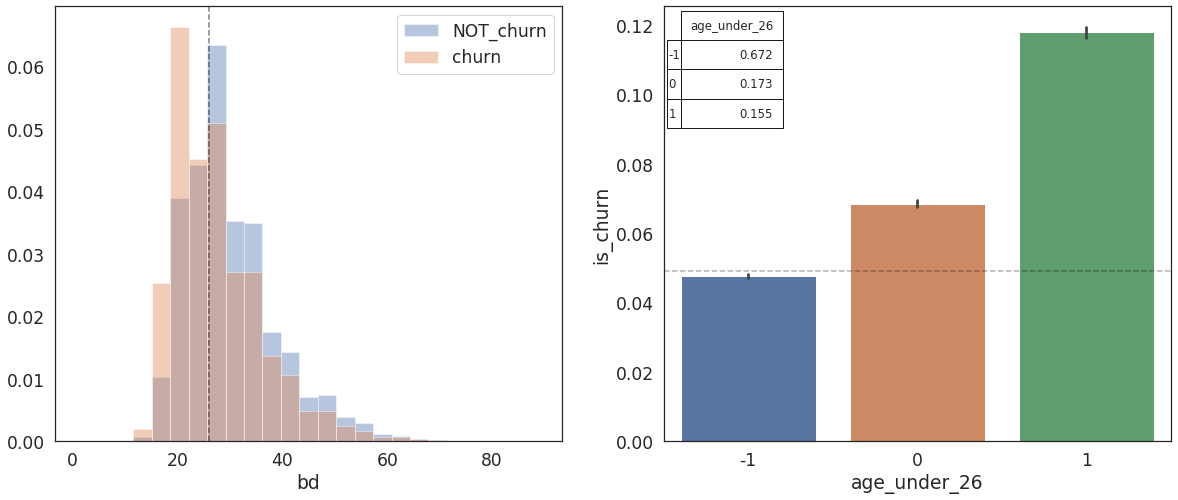

In [26]:
sns.set(font_scale=1.56)
from pandas.plotting import table

# create fig and ax 
with sns.axes_style('white'):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(20,8))
# distribution
    NOT_churn = ( (df_member.is_churn == 0) & (df_member.bd > 0 ) & (df_member.bd < 90) )
    churn = ( (df_member.is_churn == 1) & (df_member.bd > 0 ) & (df_member.bd < 90) )
    bins= 25
    sns.distplot(df_member.loc[NOT_churn,'bd'],kde=False,label='NOT_churn',ax=ax1,norm_hist=True,bins=bins)
    sns.distplot(df_member.loc[churn,'bd'],kde=False,label='churn',ax=ax1,norm_hist=True,bins=bins)
    ax1.legend()
    ax1.axvline(26,linestyle='dashed',c='black',alpha=.5)

# 判斷年紀 bd<26 == 1, bd>26 ==0 , other = -1
    df_member['age_under_26'] = df_member.bd.apply(lambda x: 1 if 0 < x <= 26 else 0 if 26 < x <= 90 else -1)

# prepare table (% of each value)
    df_percent = pd.DataFrame( df_member['age_under_26'].value_counts().sort_index() / len(df_member) ).round(3) 
# barplot with percent table
    sns.barplot(x='age_under_26',y='is_churn',data=df_member,ax=ax2)
    ax2.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
    table(ax2, df_percent,bbox=[0.035, 0.72, 0.2, 0.27])

### Transactions

In [28]:
df_tran = pd.read_csv('~/data/kkbox/transactions.csv')
df_tran2 = pd.read_csv('~/data/kkbox/transactions_v2.csv')
df_trans_all = pd.concat([df_tran, df_tran2])
df_trans_all.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [36]:
df_train_all = pd.merge(df_train, df_trans_all, how='left',on=['msno'])
df_train_all.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,38,7,0,0,0,20161031,20161107,0
1,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,38,30,149,149,0,20170107,20170206,0
2,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,39,30,149,149,1,20161031,20161221,0
3,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,39,30,149,149,1,20160715,20160821,0
4,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,39,30,149,149,1,20160831,20161021,0


處理日期

In [31]:
def dtype_compressor(df):
  # object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    # apply的方法(很慢)
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [32]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y%m%d') for date in s.unique()}
    return s.map(dates)

In [39]:
date_rename = {'transaction_date':'trans_date', 'membership_expire_date':'mem_expire_date'}
df_train_all.rename(columns=date_rename,inplace=True)

apply跟向量化的差異很大

In [34]:
%%time
df_train_all = dtype_compressor(df_train_all)

CPU times: user 33.8 s, sys: 3.48 s, total: 37.3 s
Wall time: 9.89 s


In [40]:
%%time
d = ['trans_date', 'mem_expire_date']
for col in d:
  df_train_all[col] = fast_datetime(df_train_all[col])

CPU times: user 3.73 s, sys: 1.54 s, total: 5.27 s
Wall time: 953 ms


In [35]:
print("Traning_set missing:\n",np.around(df_train_all.isnull().sum() / df_train_all.shape[0],decimals=3))

Traning_set missing:
 msno                  0.0
is_churn              0.0
payment_method_id     0.0
payment_plan_days     0.0
plan_list_price       0.0
actual_amount_paid    0.0
is_auto_renew         0.0
trans_date            0.0
mem_expire_date       0.0
is_cancel             0.0
dtype: float64


In [41]:
df_train_all = df_train_all.sort_values(by=['msno','trans_date'])
df_train_all.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,trans_date,mem_expire_date,is_cancel
5253119,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2016-11-16,2016-12-15,0
5253121,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2016-12-15,2017-01-15,0
5253118,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-01-15,2017-02-15,0
5253120,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-02-15,2017-03-15,0
5253122,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-03-15,2017-04-15,0


計算合約天數

In [43]:
# 不支援 datetime格式
# df_train_all = df_train_all.eval('membership = mem_expire_date - trans_date') 
df_train_all['membership'] = df_train_all['mem_expire_date'] - df_train_all['trans_date']

# 向量化
df_train_all['membership_int'] = df_train_all.membership / np.timedelta64(1,'D')

pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train_all[['membership_int','payment_plan_days']].describe()

,membership_int,payment_plan_days
count,17017504.000,17017504.000
mean,39.561,29.985
std,94.316,17.826
min,-17217.000,0.000
25%,30.000,30.000
50%,31.000,30.000
75%,31.000,30.000
max,3158.000,450.000


`如果是曾經流失過的使用者，又回鍋使用kkbox，則之後流失的機率也會比較高`

In [ ]:
min_date = df_train_all.membership_int.min()
# 會員持續日期小於 -30天
con = ((df_train_all.membership_int.between(min_date, -30)) & (df_train_all.is_cancel == 0))
df_train_all.loc[con,'payment_plan_days'].value_counts().sort_index()

處理資料

In [52]:
def fast_time_delta(s):
    intervals = {interval:pd.to_timedelta(interval,unit='D') for interval in s.unique()}
    return s.map(intervals)

negtive min_date ~ -30 days

is_cancel = 0
  Clean up use:
    # engineered payment_plan_days_time_delta --> plan_days_td
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0  --> expire = trans + 30 days (explored first with actual_amount_paid)
    # the actual_amount_paid could be check on Summarization above

In [53]:
df_train_all.loc[con, 'mem_expire_date'] = df_train_all.loc[con, 'trans_date'] 
df_train_all['plan_days_td'] = fast_time_delta(df_train_all.payment_plan_days)

In [54]:
  # not_0_plan_days
con = ((df_train_all.membership_int.between(min_date,-30)) & (df_train_all.is_cancel == 0))
not_0_plan_days = ~ (df_train_all.payment_plan_days.isin([0]))
df_train_all.loc[con & not_0_plan_days,'mem_expire_date'] = df_train_all.loc[con & not_0_plan_days,'trans_date'] + \
df_train_all.loc[con & not_0_plan_days,'plan_days_td']

  # are_0_plan_days
are_0_plan_days = df_train_all.payment_plan_days.isin([0])
df_train_all.loc[con & are_0_plan_days,'mem_expire_date'] = df_train_all.loc[con & are_0_plan_days,'trans_date'] + pd.Timedelta('30 days')

positive 450 days ~ max_date

In [55]:
# is_cancel = 1
  # Clean up by replaceing trans_date 
max_date = df_train_all.membership_int.max()
con = ((df_train_all.membership_int.between(450, max_date)) & (df_train_all.is_cancel == 1))
df_train_all.loc[con, 'mem_expire_date'] = df_train_all.loc[con, 'trans_date'] 

# is_cancel = 0
  # Clean up use:
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0 
      # the  30 days case --> expire = trans + 30 days
      # the 400 days case --> expire = trnas + 400 days


# payment_plan_day not 0
con = ((df_train_all.membership_int.between(450,max_date)) & (df_train_all.is_cancel == 0))
not_0_plan_days = ~ (df_train_all.payment_plan_days.isin([0]))
df_train_all.loc[con & not_0_plan_days,'mem_expire_date'] = df_train_all.loc[con & not_0_plan_days,'trans_date'] + \
df_train_all.loc[con & not_0_plan_days,'plan_days_td']

# plan_days = 0 infer by actual_amount_paid
# the 30 days case

con = (df_train_all.payment_plan_days == 0) & (df_train_all.membership_int > 450)

paid_30_days = df_train_all.actual_amount_paid.isin([100,119,129,149])
df_train_all.loc[con & paid_30_days , 'mem_expire_date'] = \
df_train_all.loc[con & paid_30_days, 'trans_date'] + pd.Timedelta('30 days')

# plan_days = 0 infer by actual_amount_paid
# the 400 days case
paid_400_days = df_train_all.actual_amount_paid.isin([1599,1788])
df_train_all.loc[con & paid_400_days , 'mem_expire_date'] = \
df_train_all.loc[con & paid_400_days, 'trans_date'] + pd.Timedelta('400 days')

非連續使用的使用者(last_last_churn = 1)